In [4]:
#######################################################################################################################
#### from-scratch illustration of AdaBoost with decision stumps
#######################################################################################################################

# load modules
import numpy as np
import pdb # helpful for debugging..
import matplotlib.pyplot as plt

In [5]:
##############################################################################################
#### Key Ingredient: Computation of optimal decision stump given observation-specific weights
##############################################################################################

# Perm --- n x d permutation matrix for sorting features 

def opt_decisionstump(X, y, weights, Perm):
    n = np.shape(X)[0]
    d = np.shape(X)[1]
    errs = np.zeros([d, 1])
    ts = np.zeros([d, 1])
    cs = np.zeros([d, 2])
        
    err_max = np.sum(weights) # maximum error
    
    for j in range(d):
        yperm = y[Perm[:,j]]
        yperm_flip = yperm[::-1]
        #
        weights_perm = weights[Perm[:,j]]
        weights_perm_flip = weights_perm[::-1]
        
        errs_plus_minus_left = np.concatenate((np.zeros(1), np.cumsum((yperm != 1) * weights_perm)))
        errs_plus_minus_right = np.append(np.cumsum((yperm_flip != -1) * weights_perm_flip)[::-1], 0)
        
        errs_plus_minus = (1.0*(errs_plus_minus_left + errs_plus_minus_right))/err_max
        
        errs_minus_plus = 1.0 - errs_plus_minus# flip everything
        
         
        ix_plus_minus  = np.argmin(errs_plus_minus)
        ix_minus_plus  = np.argmin(errs_minus_plus)
        err_plus_minus = errs_plus_minus[ix_plus_minus]
        err_minus_plus = errs_minus_plus[ix_minus_plus]

        Xj = X[:,j]
        Xj_perm = Xj[Perm[:,j]]
        #
        if err_plus_minus < err_minus_plus:
           errs[j] = err_plus_minus
           if ix_plus_minus == n: # wrap around
               ts[j] = Xj_perm[0]
               cs[j,:] = np.array([1,-1]) 
           else:
               ts[j] = Xj_perm[ix_plus_minus]
               cs[j,:] = np.array([-1,1]) 
        else:
            errs[j] = err_minus_plus
            if ix_minus_plus == n: # wrap around
                ts[j] = Xj_perm[0]
                cs[j,:] = np.array([-1,1]) 
            else:
                ts[j] = Xj_perm[ix_minus_plus]
                cs[j,:] = np.array([1,-1]) 
            
                
    jstar = np.argmin(errs)            
    err_star = errs[jstar]
    tstar = ts[jstar]
    cstar = cs[jstar,:]            
          
    return({'feature': jstar, 'thres': tstar, 'cs': cstar, 'err': err_star})

In [7]:
### now main boosting function

# X: features, y: labels (-/+1 ), M= number of boosting iterations

def adaboost(X, y, M):
    
    jstars = np.zeros([M, 1], dtype=int)
    errstars_w = np.zeros([M, 1])
    tstars = np.zeros([M, 1])   
    cstars = np.zeros([M, 2])
    alphas = np.zeros([M, 1])
    
    n = len(y)
    weights = np.ones([n, 1])/n
    
    ### sort X's once at the beginning
    Perm = np.apply_along_axis(np.argsort, 0, X, 0)
    ### 
    for m in range(M):
        res_stump = opt_decisionstump(X, y, weights, Perm)
        jstars[m] = res_stump['feature']
        tstars[m] = res_stump['thres']
        cstars[m,:] = res_stump['cs']
        err_stump   = res_stump['err'] 
        errstars_w[m] = err_stump
        #
        
        alpha = 0
        if err_stump < 0.5:
            alpha = np.log((1.0-err_stump)/err_stump)
        if alpha > 10:
            alpha = 10 ### truncate too large weights
        alphas[m] = alpha
        #
        gtr = (X[:,jstars[m]] >= tstars[m] - 0.001) ## small correction factor --- numerical correction
        pred_m = gtr * cstars[m,0]  + (1 - gtr) * cstars[m,1]
        #
        ind_m = np.abs(pred_m - y) > 1
        weights = weights * np.exp(alpha * ind_m) 
        weights = weights / sum(weights)
        
        
    return({'features': jstars, 'thres': tstars, 'cs': cstars, 'alphas': alphas, 'err': errstars_w})

In [8]:
### "predict" function given an ensemble of decision stumps

def predict_adaboost(x, adaboost_res):
        
    jstars = adaboost_res["features"]
    tstars = adaboost_res["thres"]
    cstars = adaboost_res["cs"]
    alphas = adaboost_res["alphas"]
    
    gtr = (x[jstars] >= (tstars - 0.001))
    
    pred =  gtr * cstars[:,0,None] + (1 - gtr) * cstars[:,1,None]

    pred = np.cumsum(pred * alphas)
    pred = np.sign(pred)
    
    return(pred)

In [15]:
### simulation example
    
np.random.seed(5100217)

ntrain = 1000
ntest = 10000
d = 100
ts = np.array([0.4, 0.2, 0.7, 0.8, 0.3])

xtrain = np.c_[np.random.rand(ntrain, d)]
xtest  = np.c_[np.random.rand(ntest, d)]

noiseprob = 0.1       
          
ytrain = (2 * (np.sum(2*(xtrain[:,0:5] - ts > 0)-1, 1) > 0) - 1) * (np.sign(np.random.rand(ntrain) - noiseprob)) 
ytest = (2 * (np.sum(2*(xtest[:,0:5] - ts > 0)-1, 1) > 0) - 1)   * (np.sign(np.random.rand(ntest)  - noiseprob))    

M = 100
boost_res = adaboost(xtrain, np.expand_dims(ytrain, 1), M)


allpred = np.zeros([ntrain,M])
mis_train = np.zeros([ntrain, M])    
for i in range(np.shape(xtrain)[0]):
    allpred[i,:] = predict_adaboost(xtrain[i,:], boost_res)    
    mis_train[i,:] = np.abs((ytrain[i] - allpred[i,:])) * 0.5

Text(0.5, 1.0, 'training error -- label noise')

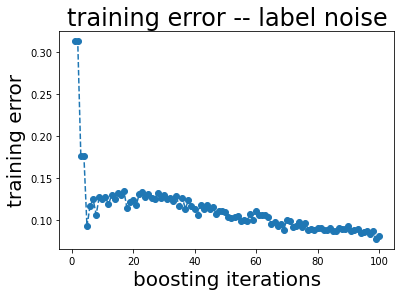

In [16]:
### Visualize results --- training error

ax = plt.subplot()

ax.plot(np.arange(M)+1,  np.mean(mis_train, 0), '--o')

ax.set_xlabel('boosting iterations', fontsize = 20)
ax.set_ylabel('training error', fontsize = 20)
ax.set_title('training error -- label noise', fontsize = 24)    

Text(0.5, 1.0, 'test error -- label noise')

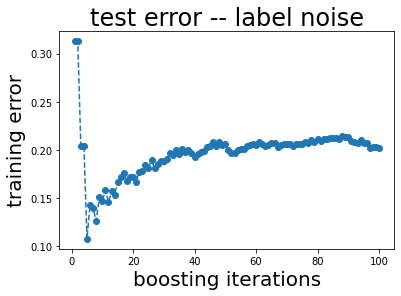

In [17]:
### Visualize results --- test error
    
allpred = np.zeros([ntest,M])
mis_test = np.zeros([ntest, M])    
for i in range(np.shape(xtest)[0]):
    allpred[i,:] = predict_adaboost(xtest[i,:], boost_res)    
    mis_test[i,:] = np.abs((ytest[i] - allpred[i,:])) * 0.5


ax = plt.subplot()

ax.plot(np.arange(M)+1,  np.mean(mis_test, 0), '--o')

ax.set_xlabel('boosting iterations', fontsize = 20)
ax.set_ylabel('training error', fontsize = 20)
ax.set_title('test error -- label noise', fontsize = 24)    

Text(0.5, 1.0, 'fitted functions per feature')

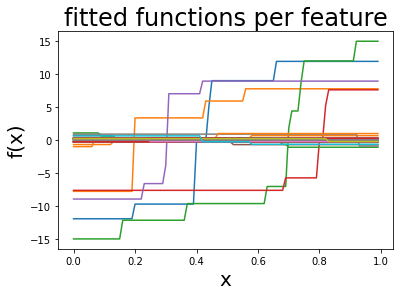

In [18]:
### component functions
ax = plt.subplot()

for ix in range(100):
    xgrid = np.arange(0,1,0.01)
    
    ix_sel = np.where(np.squeeze(boost_res["features"]) == ix)
    thres = boost_res["thres"][ix_sel]
    cs = boost_res["cs"][ix_sel,:]
    cs = np.reshape(cs, np.shape(cs)[1:3])
    alphas = boost_res["alphas"][ix_sel]
    
    def foo(x):
        f = np.sum(alphas * (cs[:,0] * (x >= thres - 0.001) + cs[:,1] * (1 - (x >= thres - 0.001)))) 
        return(f)
    
    fvals = np.array([foo(x) for x in xgrid])
    ax.plot(xgrid, fvals)
    
    
ax.set_xlabel('x', fontsize = 20)
ax.set_ylabel('f(x)', fontsize = 20)
ax.set_title('fitted functions per feature', fontsize = 24)    